In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
from scipy import interpolate
import grafteaux as G
from tqdm import tqdm 


### Import PIV data

In [2]:
G = reload(G)
mpath = "C:/Users/Student User/Downloads"
X, Y, U, V,Swirl, Cond,Prof, SwirlFiltPro, SwirlFiltRet, SwirlFilt = G.init_data(mat_path = mpath)
Umean = Prof['U']


current path : C:\Users\Student User\anaconda3\python.exe
['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']


C:\Users\Student User\Desktop\superResolution\PIVutils.py:27: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(path)
C:\Users\Student User\Desktop\superResolution\PIVutils.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  TempS = {k : f[i][k].value       #Generate a dictionary linking all values in cond with their names


0.2439601862683396


In [3]:
def rf(f):
    '''
    Inverts vector data (f)
    '''
    return [f[len(f)-i-1] for i in range(len(f))]



### Function to generate low-resolution training data

In [4]:
#generate a low res input that actually has a lower size 
#maybe if the redundancies in inputs are removed, then the val-loss might be lower?

In [5]:
def lowV3(a, bin_):
    #returns the low res image with a low res size 
    from PIL import Image
    s1, s2 = a.shape[0]//bin_, a.shape[1]//bin_
    return np.array(Image.fromarray(a).resize([s2, s1], resample = Image.BILINEAR))


### Max - pooling low resolution testing

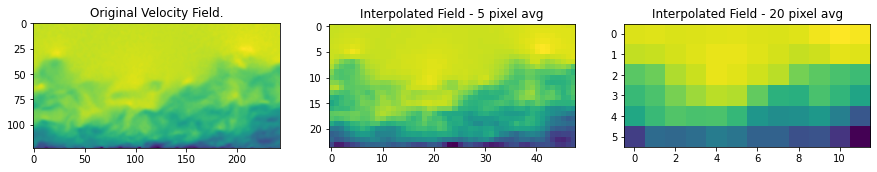

In [6]:
pt = rf(U[:,:,0])
pt2 = lowV3(np.array(pt), 5)
pt3 = lowV3(np.array(pt), 20)


plt.figure(figsize = (15,10))
plt.subplot(1,3,1)
plt.imshow(pt/np.max(pt))
plt.title('Original Velocity Field.')
plt.subplot(1,3,2)
plt.imshow(pt2)
plt.title('Interpolated Field - 5 pixel avg')
plt.subplot(1,3,3)
plt.imshow(pt3)
plt.title('Interpolated Field - 20 pixel avg')
plt.show()

### Generating training data from PIV data

In [7]:
data_ins = []
data_outs = []

dim = 15
umean2  = np.array([Umean[:,0] for i in range(U.shape[1])]).T

for i in tqdm(range(750)):
    
    c_frame = U[:,:,i]-umean2
    c_frame = c_frame/np.nanmax(c_frame)
    
    do = (c_frame).flatten()
    di = lowV3(c_frame,5).flatten()
    data_ins.append(np.nan_to_num(di))
    data_outs.append(np.nan_to_num(do))

100%|██████████| 750/750 [00:01<00:00, 455.74it/s]


### Spliting into training and validation data

In [35]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_ins, data_outs, test_size=0.05, shuffle= True)

#### looking at a sample training input and training output

In [9]:
yshape = U[:,:,0].shape
xsh = lowV3(U[:,:,0],5)
xshape = xsh.shape

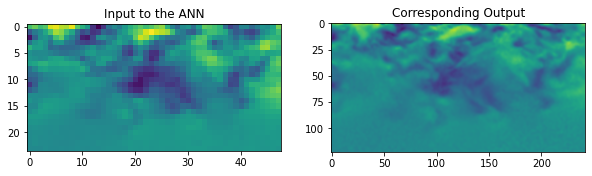

In [10]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(np.array(x_train[0]).reshape(xshape))
plt.title('Input to the ANN')
plt.subplot(1,2,2)
plt.imshow(np.array(y_train[0]).reshape(yshape))
plt.title('Corresponding Output')
plt.show()


### Building the ANN - Keras Sequential Model

In [11]:
#swish activation function - basically relu but better

from tensorflow.keras.backend import sigmoid
from tensorflow.python.keras.utils.generic_utils import get_custom_objects 
from tensorflow.keras.layers import Activation 

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish': Activation(swish)}) 


### ANN model 

#### Benjamen et al.(2020) Shallow decoder model parameters for forced isotropic turbulence superresolution

In [27]:
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
xsh = lowV3(U[:,:,0],5)

input_shape = xsh.flatten().shape
output_shape = U[:,:,0].flatten().shape

model = keras.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Dense(input_shape[0],
                       activation = 'tanh', 
                       use_bias = True, 
                       kernel_regularizer = regularizers.l2(1e-5),
                       activity_regularizer = regularizers.l2(1e-7)
                       
                       ),
    
    #keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(input_shape[0],
                       activation = 'tanh',
                       use_bias = True,
                       kernel_regularizer = regularizers.l2(1e-5),
                       activity_regularizer = regularizers.l2(1e-7)
                       
                       ),
    
    #keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(input_shape[0],
                       activation = 'tanh',
                       use_bias = True
                       ),
    
    
    #keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    
    
    keras.layers.Dense(output_shape[0])
])

lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=1e-3,
    decay_steps=20,
    decay_rate=0.5)


adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule,
                                beta_1=0.9,
                                beta_2=0.999)


model.compile(optimizer=adam ,
              
              loss='mean_squared_error',
              metrics=['mse'])

history = model.fit(np.array(x_train),
                    np.array(y_train),
                    shuffle = True,
                    validation_split = 0.1,
                    epochs=500,
                    batch_size=128)



Epoch 1/500
5/5 [==============================] - 8s 2s/step - loss: 0.0871 - mse: 0.0645 - val_loss: 0.0778 - val_mse: 0.0557
Epoch 2/500
5/5 [==============================] - 3s 570ms/step - loss: 0.0688 - mse: 0.0472 - val_loss: 0.0664 - val_mse: 0.0453
Epoch 3/500
5/5 [==============================] - 3s 574ms/step - loss: 0.0600 - mse: 0.0393 - val_loss: 0.0598 - val_mse: 0.0396
Epoch 4/500
5/5 [==============================] - 3s 547ms/step - loss: 0.0539 - mse: 0.0340 - val_loss: 0.0551 - val_mse: 0.0356
Epoch 5/500
5/5 [==============================] - 3s 528ms/step - loss: 0.0495 - mse: 0.0302 - val_loss: 0.0510 - val_mse: 0.0322
Epoch 6/500
5/5 [==============================] - 3s 569ms/step - loss: 0.0460 - mse: 0.0274 - val_loss: 0.0480 - val_mse: 0.0298
Epoch 7/500
5/5 [==============================] - 3s 561ms/step - loss: 0.0430 - mse: 0.0250 - val_loss: 0.0458 - val_mse: 0.0282
Epoch 8/500
5/5 [==============================] - 3s 574ms/step - loss: 0.0408 - mse:

5/5 [==============================] - 3s 561ms/step - loss: 0.0189 - mse: 0.0107 - val_loss: 0.0243 - val_mse: 0.0161
Epoch 64/500
5/5 [==============================] - 3s 572ms/step - loss: 0.0188 - mse: 0.0106 - val_loss: 0.0241 - val_mse: 0.0159
Epoch 65/500
5/5 [==============================] - 3s 506ms/step - loss: 0.0188 - mse: 0.0106 - val_loss: 0.0241 - val_mse: 0.0160
Epoch 66/500
5/5 [==============================] - 3s 573ms/step - loss: 0.0187 - mse: 0.0106 - val_loss: 0.0239 - val_mse: 0.0159
Epoch 67/500
5/5 [==============================] - 3s 565ms/step - loss: 0.0185 - mse: 0.0105 - val_loss: 0.0239 - val_mse: 0.0159
Epoch 68/500
5/5 [==============================] - 3s 566ms/step - loss: 0.0185 - mse: 0.0105 - val_loss: 0.0238 - val_mse: 0.0159
Epoch 69/500
5/5 [==============================] - 3s 557ms/step - loss: 0.0184 - mse: 0.0105 - val_loss: 0.0237 - val_mse: 0.0158
Epoch 70/500
5/5 [==============================] - 3s 528ms/step - loss: 0.0183 - mse: 0

Epoch 125/500
5/5 [==============================] - 3s 547ms/step - loss: 0.0155 - mse: 0.0093 - val_loss: 0.0209 - val_mse: 0.0148
Epoch 126/500
5/5 [==============================] - 3s 569ms/step - loss: 0.0154 - mse: 0.0093 - val_loss: 0.0209 - val_mse: 0.0148
Epoch 127/500
5/5 [==============================] - 3s 576ms/step - loss: 0.0154 - mse: 0.0093 - val_loss: 0.0208 - val_mse: 0.0147
Epoch 128/500
5/5 [==============================] - 3s 570ms/step - loss: 0.0153 - mse: 0.0092 - val_loss: 0.0208 - val_mse: 0.0147
Epoch 129/500
5/5 [==============================] - 3s 553ms/step - loss: 0.0153 - mse: 0.0092 - val_loss: 0.0208 - val_mse: 0.0147
Epoch 130/500
5/5 [==============================] - 3s 557ms/step - loss: 0.0153 - mse: 0.0092 - val_loss: 0.0208 - val_mse: 0.0147
Epoch 131/500
5/5 [==============================] - 3s 577ms/step - loss: 0.0152 - mse: 0.0092 - val_loss: 0.0207 - val_mse: 0.0147
Epoch 132/500
5/5 [==============================] - 3s 574ms/step - 

5/5 [==============================] - 3s 587ms/step - loss: 0.0140 - mse: 0.0087 - val_loss: 0.0195 - val_mse: 0.0142
Epoch 187/500
5/5 [==============================] - 3s 565ms/step - loss: 0.0139 - mse: 0.0087 - val_loss: 0.0195 - val_mse: 0.0142
Epoch 188/500
5/5 [==============================] - 3s 557ms/step - loss: 0.0139 - mse: 0.0087 - val_loss: 0.0194 - val_mse: 0.0142
Epoch 189/500
5/5 [==============================] - 3s 555ms/step - loss: 0.0139 - mse: 0.0087 - val_loss: 0.0194 - val_mse: 0.0142
Epoch 190/500
5/5 [==============================] - 3s 574ms/step - loss: 0.0139 - mse: 0.0087 - val_loss: 0.0194 - val_mse: 0.0142
Epoch 191/500
5/5 [==============================] - 3s 574ms/step - loss: 0.0139 - mse: 0.0087 - val_loss: 0.0194 - val_mse: 0.0142
Epoch 192/500
5/5 [==============================] - 3s 563ms/step - loss: 0.0138 - mse: 0.0087 - val_loss: 0.0193 - val_mse: 0.0142
Epoch 193/500
5/5 [==============================] - 3s 549ms/step - loss: 0.0138 -

Epoch 248/500
5/5 [==============================] - 3s 546ms/step - loss: 0.0131 - mse: 0.0084 - val_loss: 0.0186 - val_mse: 0.0139
Epoch 249/500
5/5 [==============================] - 3s 572ms/step - loss: 0.0131 - mse: 0.0084 - val_loss: 0.0186 - val_mse: 0.0139
Epoch 250/500
5/5 [==============================] - 3s 575ms/step - loss: 0.0130 - mse: 0.0084 - val_loss: 0.0186 - val_mse: 0.0139
Epoch 251/500
5/5 [==============================] - 3s 570ms/step - loss: 0.0130 - mse: 0.0084 - val_loss: 0.0185 - val_mse: 0.0139
Epoch 252/500
5/5 [==============================] - 3s 565ms/step - loss: 0.0130 - mse: 0.0083 - val_loss: 0.0185 - val_mse: 0.0139
Epoch 253/500
5/5 [==============================] - 3s 558ms/step - loss: 0.0130 - mse: 0.0084 - val_loss: 0.0185 - val_mse: 0.0139
Epoch 254/500
5/5 [==============================] - 3s 591ms/step - loss: 0.0130 - mse: 0.0084 - val_loss: 0.0185 - val_mse: 0.0138
Epoch 255/500
5/5 [==============================] - 3s 572ms/step - 

5/5 [==============================] - 3s 572ms/step - loss: 0.0125 - mse: 0.0082 - val_loss: 0.0180 - val_mse: 0.0137
Epoch 310/500
5/5 [==============================] - 3s 572ms/step - loss: 0.0125 - mse: 0.0082 - val_loss: 0.0180 - val_mse: 0.0137
Epoch 311/500
5/5 [==============================] - 3s 546ms/step - loss: 0.0125 - mse: 0.0081 - val_loss: 0.0180 - val_mse: 0.0137
Epoch 312/500
5/5 [==============================] - 3s 572ms/step - loss: 0.0124 - mse: 0.0081 - val_loss: 0.0180 - val_mse: 0.0136
Epoch 313/500
5/5 [==============================] - 3s 574ms/step - loss: 0.0124 - mse: 0.0081 - val_loss: 0.0179 - val_mse: 0.0136
Epoch 314/500
5/5 [==============================] - 3s 574ms/step - loss: 0.0124 - mse: 0.0081 - val_loss: 0.0179 - val_mse: 0.0136
Epoch 315/500
5/5 [==============================] - 3s 551ms/step - loss: 0.0124 - mse: 0.0081 - val_loss: 0.0180 - val_mse: 0.0137
Epoch 316/500
5/5 [==============================] - 3s 559ms/step - loss: 0.0124 -

Epoch 371/500
5/5 [==============================] - 3s 576ms/step - loss: 0.0121 - mse: 0.0080 - val_loss: 0.0175 - val_mse: 0.0135
Epoch 372/500
5/5 [==============================] - 3s 572ms/step - loss: 0.0120 - mse: 0.0080 - val_loss: 0.0175 - val_mse: 0.0135
Epoch 373/500
5/5 [==============================] - 3s 578ms/step - loss: 0.0120 - mse: 0.0080 - val_loss: 0.0176 - val_mse: 0.0135
Epoch 374/500
5/5 [==============================] - 3s 563ms/step - loss: 0.0120 - mse: 0.0080 - val_loss: 0.0175 - val_mse: 0.0135
Epoch 375/500
5/5 [==============================] - 3s 552ms/step - loss: 0.0120 - mse: 0.0080 - val_loss: 0.0175 - val_mse: 0.0135
Epoch 376/500
5/5 [==============================] - 3s 571ms/step - loss: 0.0120 - mse: 0.0080 - val_loss: 0.0176 - val_mse: 0.0135
Epoch 377/500
5/5 [==============================] - 3s 574ms/step - loss: 0.0120 - mse: 0.0079 - val_loss: 0.0175 - val_mse: 0.0135
Epoch 378/500
5/5 [==============================] - 3s 575ms/step - 

5/5 [==============================] - 2s 355ms/step - loss: 0.0117 - mse: 0.0079 - val_loss: 0.0173 - val_mse: 0.0134
Epoch 433/500
5/5 [==============================] - 2s 337ms/step - loss: 0.0117 - mse: 0.0078 - val_loss: 0.0172 - val_mse: 0.0134
Epoch 434/500
5/5 [==============================] - 2s 326ms/step - loss: 0.0117 - mse: 0.0078 - val_loss: 0.0172 - val_mse: 0.0134
Epoch 435/500
5/5 [==============================] - 2s 327ms/step - loss: 0.0117 - mse: 0.0079 - val_loss: 0.0172 - val_mse: 0.0134
Epoch 436/500
5/5 [==============================] - 2s 325ms/step - loss: 0.0117 - mse: 0.0079 - val_loss: 0.0172 - val_mse: 0.0134
Epoch 437/500
5/5 [==============================] - 2s 325ms/step - loss: 0.0117 - mse: 0.0078 - val_loss: 0.0172 - val_mse: 0.0134
Epoch 438/500
5/5 [==============================] - 2s 328ms/step - loss: 0.0117 - mse: 0.0078 - val_loss: 0.0172 - val_mse: 0.0134
Epoch 439/500
5/5 [==============================] - 2s 330ms/step - loss: 0.0117 -

Epoch 494/500
5/5 [==============================] - 2s 359ms/step - loss: 0.0115 - mse: 0.0078 - val_loss: 0.0170 - val_mse: 0.0133
Epoch 495/500
5/5 [==============================] - 2s 331ms/step - loss: 0.0114 - mse: 0.0077 - val_loss: 0.0169 - val_mse: 0.0133
Epoch 496/500
5/5 [==============================] - 2s 326ms/step - loss: 0.0114 - mse: 0.0078 - val_loss: 0.0170 - val_mse: 0.0133
Epoch 497/500
5/5 [==============================] - 2s 327ms/step - loss: 0.0114 - mse: 0.0078 - val_loss: 0.0169 - val_mse: 0.0133
Epoch 498/500
5/5 [==============================] - 2s 329ms/step - loss: 0.0114 - mse: 0.0078 - val_loss: 0.0169 - val_mse: 0.0133
Epoch 499/500
5/5 [==============================] - 2s 325ms/step - loss: 0.0114 - mse: 0.0078 - val_loss: 0.0169 - val_mse: 0.0133
Epoch 500/500
5/5 [==============================] - 2s 329ms/step - loss: 0.0114 - mse: 0.0077 - val_loss: 0.0169 - val_mse: 0.0133


### Compile and fit 

In [28]:
#ideas 
#1. l1 200 l2 500 - val_loss ~ 0.015
#1. use over complete first layer - more neurons than input size 
#2. decrease lr to 0.01 and also try exponential lr decay

#### Save the ANN model

In [36]:
model.evaluate(np.array(x_test), np.array(y_test))

2/2 [==============================] - 0s 19ms/step - loss: 0.0097 - mse: 0.0060


[0.009715047664940357, 0.006049850024282932]

In [37]:
#model.save('C:/Users/Kommalapati sahil/Desktop/Brunton/ANN10k')-

### Training and testing convergence histories

In [31]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

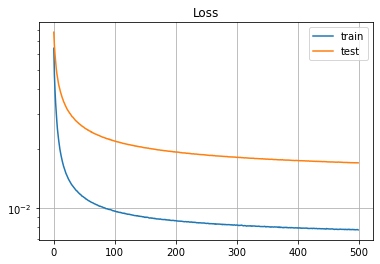

In [32]:

plt.title('Loss')
plt.semilogy(history.history['mse'], label='train')
plt.semilogy(history.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.show()

### Reconstructed high resolution Images from ANN 

#### Using Test data set to observe model accuracy for reconstruction

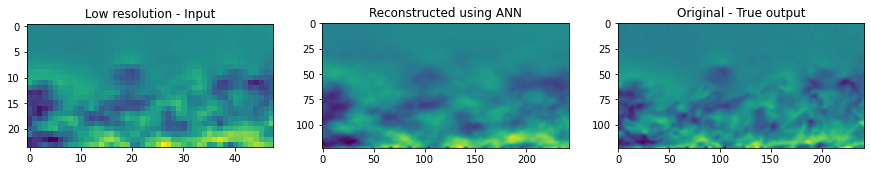

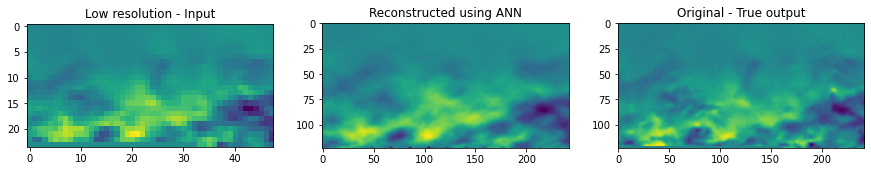

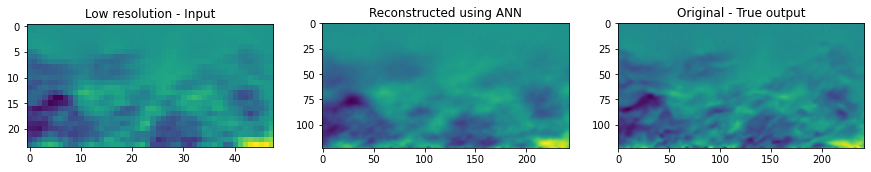

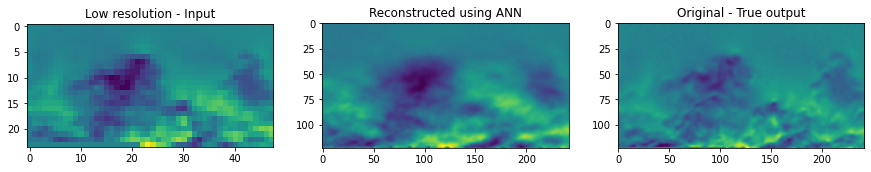

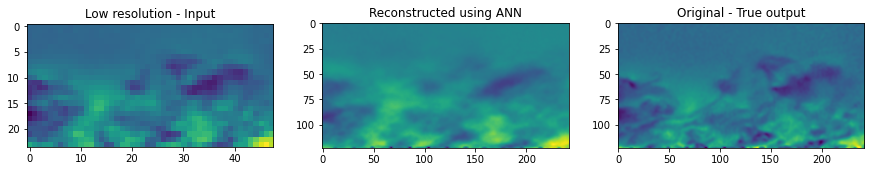

In [40]:
for i in range(2,7):
    plt.figure(figsize = (15,10))

    plt.subplot(1,3,1)
    plt.imshow(rf(x_test[i].reshape(xshape)))
    plt.title('Low resolution - Input')
    y_pred0 = model.predict(np.array([x_test[i]]))

    plt.subplot(1,3,2)
    plt.imshow(rf(y_pred0.reshape(yshape)))
    plt.title('Reconstructed using ANN')

    plt.subplot(1,3,3)
    plt.imshow(rf(y_test[i].reshape(yshape)))
    plt.title('Original - True output')
    plt.show()

### Looking at training cases reconstruction 

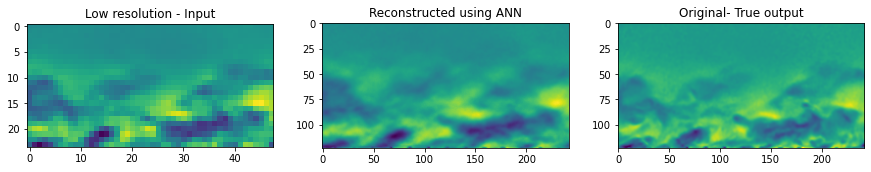

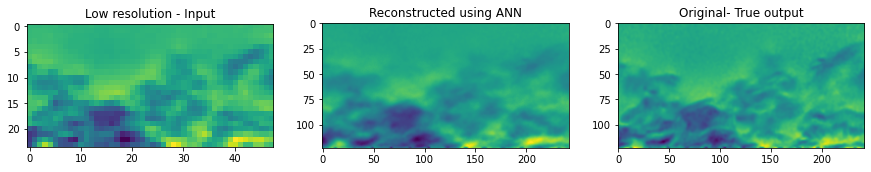

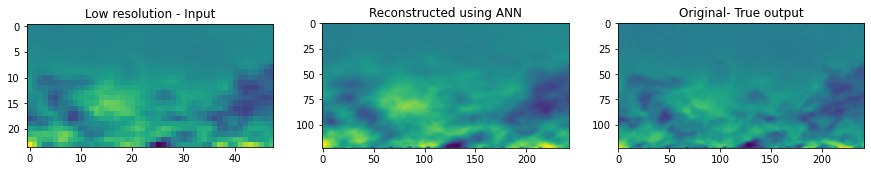

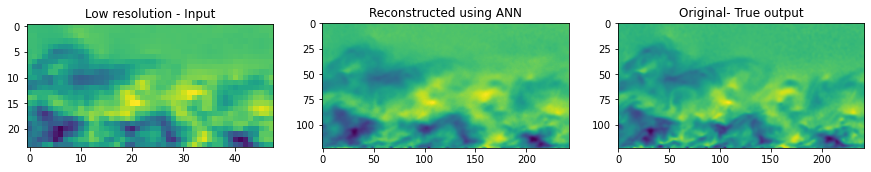

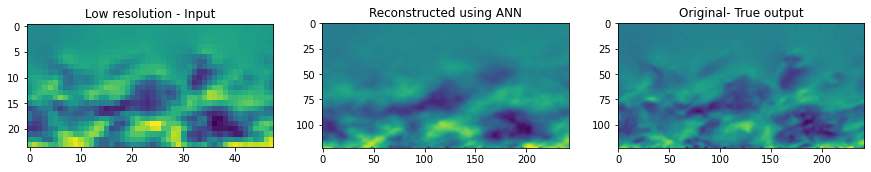

In [41]:
for i in range(5):
    plt.figure(figsize = (15,10))

    plt.subplot(1,3,1)
    plt.imshow(rf(x_train[i].reshape(xshape)))
    plt.title('Low resolution - Input')
    y_pred0 = model.predict(np.array([x_train[i]]))

    plt.subplot(1,3,2)
    plt.imshow(rf(y_pred0.reshape(yshape)))
    plt.title('Reconstructed using ANN')

    plt.subplot(1,3,3)
    plt.imshow(rf(y_train[i].reshape(yshape)))
    plt.title('Original- True output')
    plt.show()